In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
import scipy.io as sio
from scipy.stats import pearsonr
from scipy import ndimage as nd
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import theano
import theano.tensor as T

import src.pyNumpyUtility as pnu
import src.pyFWRF as prf    
from src.pyFWRF import FWRF_model, fpX

Couldn't import dot_parser, loading of dot files will not be possible.
theano floatX: float32
numpy floatX: <type 'numpy.float32'>


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# folder in which resides the vim-1, dataset, the precalculated feature space and the image dataset.
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

In [3]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"

print "Time Stamp: %s" % timestamp

Time Stamp: Mar-25-2017_1549


In [4]:
def save_stuff(save_to_this_file, data_objects_dict):
    failed = []
    with h5py.File(save_to_this_file+'.h5py', 'w') as hf:
        for k,v in data_objects_dict.iteritems():
            try:
                hf.create_dataset(k,data=v)
                print 'saved %s in h5py file' %(k)
            except:
                failed.append(k)
                print 'failed to save %s as h5py. will try pickle' %(k)   
    for k in failed:
        with open(save_to_this_file+'_'+'%s.pkl' %(k), 'w') as pkl:
            try:
                pickle.dump(data_objects_dict[k],pkl)
                print 'saved %s as pkl' %(k)
            except:
                print 'failed to save %s in any format. lost.' %(k)
                
def display_candidate_loss(scores, nx, ny, ns):
    dis_y = ns // 3 if ns%3==0 else ns//3+1
    s = scores.reshape((nx, ny, ns)).transpose((1,0,2))[::-1,:,:] ## The transpose and flip is just so that the candidate 
    #coordinate maatch the normal cartesian coordinate of the rf position when viewed through imshow.
    idxs = np.unravel_index(np.argmin(s), (nx,ny,ns))
    best = plt.Circle((idxs[1], idxs[0]), 0.5, color='r', fill=False, lw=2)
    
    fig = plt.figure(figsize=(15, 5*dis_y))
    smin = np.min(s)
    smax = np.max(s)
    print "score range = (%f, %f)" % (smin, smax)
    for i in range(ns):
        plt.subplot(dis_y, 3, i+1)
        plt.imshow(s[:,:,i], interpolation='None')
        plt.title('sigma canditate = %d' % i)
        plt.clim(smin, smax)
        if(idxs[2]==i):
            ax = plt.gca()
            ax.add_artist(best)
    return fig

# 1a) Load the low-rez images presented.

In [5]:
inputdata_lowrez = sio.loadmat(dataset_dir + "Stimuli.mat")
print inputdata_lowrez.keys()

['seqTrn', '__header__', '__globals__', 'stimVal', 'seqVal', 'stimTrn', '__version__']


In [6]:
npx = 96
npc = 3

trn_size = len(inputdata_lowrez["stimTrn"])
val_size = len(inputdata_lowrez["stimVal"])
data_size = trn_size + val_size

print "trn: %d, val: %d" % (trn_size, val_size)
inputData = np.ndarray(shape=(data_size, npx, npx, npc), dtype=fpX)

for i,rawim in enumerate(inputdata_lowrez["stimTrn"]):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)               
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    inputData[i,...] = np.asarray(im)

for i,rawim in enumerate(inputdata_lowrez["stimVal"]):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)         
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    inputData[trn_size+i,...] = np.asarray(im)
        
inputData = np.transpose((inputData - 128) / 128, (0,3,1,2))
print "Data shape = %s" % (inputData.shape,)

trnInputData = inputData[:trn_size]
valInputData = inputData[trn_size:]

trn: 1750, val: 120
Data shape = (1870, 3, 96, 96)


# 1b) Load the voxel data for all images presented.

In [7]:
voxelset = h5py.File(dataset_dir + "EstimatedResponses.mat")
print voxelset.keys()

[u'dataTrnS1', u'dataTrnS2', u'dataValS1', u'dataValS2', u'roiS1', u'roiS2', u'voxIdxS1', u'voxIdxS2']


In [9]:
subject = 'S1'
roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']

In [13]:
voxeldata = np.concatenate([voxelset['dataTrn%s'%subject], voxelset['dataVal%s'%subject]], axis=0).astype(dtype=fpX)
voxelroi = voxelset['roi%s'%subject]
voxelidx = voxelset['voxIdx%s'%subject]
print voxeldata.shape

# purge all voxel that have no variance in the validation set

voxelNanMask = ~np.isnan(voxeldata).any(axis=0)
nv = np.sum(voxelNanMask)
print "%d voxels contain valid values for all images" % nv

(1870, 25915)
22701 voxels contain valid values for all images


In [14]:
voxelData = voxeldata[:, voxelNanMask].astype(dtype=fpX)
voxelROI  = voxelroi[:, voxelNanMask]
voxelIDX  = voxelidx[:, voxelNanMask]
print voxelData.shape

trnVoxelData = voxelData[:trn_size]
valVoxelData = voxelData[trn_size:]

(1870, 22701)


## (Optional) Restricted dataset

In [12]:
nv = 300
start_v = (3566 // nv) * nv
trnVoxelData = trnVoxelData[:, start_v:start_v+nv]
valVoxelData = valVoxelData[:, start_v:start_v+nv]

# 1c) Load precomputed model feature space for all images presented.

In [15]:
model_name = 'deepnet'

trn_feature_dict = h5py.File(dataset_dir + "caffe_refnet_trn_response.h5py", 'r')   # 'r' means that hdf5 file is open in read-only mode
val_feature_dict = h5py.File(dataset_dir + "caffe_refnet_val_response.h5py", 'r')

layerlist = trn_feature_dict.keys()
print layerlist

[u'conv1', u'conv2', u'conv3', u'conv4', u'conv5', u'fc6', u'fc7', u'fc8', u'prob']


In [16]:
# concatenate and sort as list
fmap_max = 1024
order = layerlist[0:8] #+layerlist[7:8]
fmaps = []
fmaps_sizes = []
fmaps_count = 0
for l in order:
    fmap = np.concatenate((np.array(trn_feature_dict[l], dtype=fpX), np.array(val_feature_dict[l], dtype=fpX)), axis=0)        
    if fmap.ndim==2:
        fmap = fmap.reshape(fmap.shape+(1,1))
    if fmap.shape[1]>fmap_max:
        #select the feature map with the most variance to the dataset
        fmap_var = np.var(fmap, axis=(0,2,3))
        most_var = fmap_var.argsort()[-fmap_max:]
        fmap = fmap[:,most_var,:,:]
    print "layer: %s, shape=%s" % (l, (fmap.shape))
    fmaps += [fmap,]
    fmaps_sizes  += [fmap.shape,]
    fmaps_count += fmap.shape[1]
    
trn_feature_dict.close()
val_feature_dict.close()

layer: conv1, shape=(1870, 96, 55, 55)
layer: conv2, shape=(1870, 256, 27, 27)
layer: conv3, shape=(1870, 384, 13, 13)
layer: conv4, shape=(1870, 384, 13, 13)
layer: conv5, shape=(1870, 256, 13, 13)
layer: fc6, shape=(1870, 1024, 1, 1)
layer: fc7, shape=(1870, 1024, 1, 1)
layer: fc8, shape=(1870, 1000, 1, 1)


## Display an example of image and feature space.

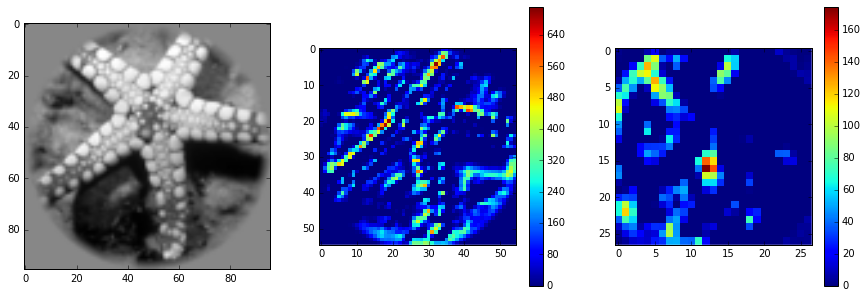

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(trnInputData[5,0,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(fmaps[0][5,2,:,:], interpolation='None')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(fmaps[1][5,10,:,:], interpolation='None')
plt.colorbar()

In [18]:
# aliases
nf = fmaps_count
fmaps_res_count = len(fmaps)
allFmaps = fmaps

# make sure we are using float32
print allFmaps[0].dtype

float32


# 2) MODELS
### There are 4 steps to the fwRF model
1) Define the model object fwrf (class FWRF_model), where the input and batch sizes are initialized.

2) Compute the model-space tensor by calling fwrf.precompute_rfw_data(...) where one can choose a nonlinearity and normalize the final tensor.

3) Run the model on the data by calling fwrf.shared_model_training(...). "Shared model" is the method, meaning that all voxels pick a model from the same grid.

4) Run the resulting voxel models on the validation set to get an accuracy score.

## Define the inputs
We can either connect the feature maps of the network directly or some precomputed values provided in a suitable list

In [19]:
#feature maps symbolic variables:
_fmaps = []
for r in range(fmaps_res_count):
    _fmaps += [T.tensor4(),] # note this has to be done explicitely, we can't just replicate the tensor object
_invar = _fmaps
# vs. connecting another theano network directly:
#_fmaps = [L.get_output(fm, deterministic=True) for fm in _aux]
#_invar = [X,]

## Define the search parameters

In [20]:
lx = ly = 20.
nx = ny = 15
smin, smax = 0.7, 8.
ns = 8

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
sharedModel_specs = [[(0., lx), (0., ly), (smin, smax)], [prf.linspace(nx), prf.linspace(ny), prf.logspace(ns)]]
# initial values of the fwrf model parameters
voxelParams = [np.full(shape=(nv, nf), fill_value=0.0, dtype=fpX), np.full(shape=(nv), fill_value=0.0, dtype=fpX)]

print "G = %d\n" % (nx*ny*ns)
#print range:
print "range x"
print sharedModel_specs[1][0](*sharedModel_specs[0][0])
print "range y"
print sharedModel_specs[1][1](*sharedModel_specs[0][1])
print "range s"
print sharedModel_specs[1][2](*sharedModel_specs[0][2])

G = 1800

range x
[ -9.33333302e+00  -8.00000000e+00  -6.66666651e+00  -5.33333349e+00
  -4.00000000e+00  -2.66666675e+00  -1.33333337e+00   3.55271368e-15
   1.33333337e+00   2.66666675e+00   4.00000000e+00   5.33333349e+00
   6.66666651e+00   8.00000000e+00   9.33333302e+00]
range y
[ -9.33333302e+00  -8.00000000e+00  -6.66666651e+00  -5.33333349e+00
  -4.00000000e+00  -2.66666675e+00  -1.33333337e+00   3.55271368e-15
   1.33333337e+00   2.66666675e+00   4.00000000e+00   5.33333349e+00
   6.66666651e+00   8.00000000e+00   9.33333302e+00]
range s
[ 0.69999999  0.99137908  1.40404642  1.98848879  2.81620884  3.98847222
  5.6486969   8.        ]


## Select the indice of one of the receptive field size to visualize the rf weight masks at every resolution required by the feature space.

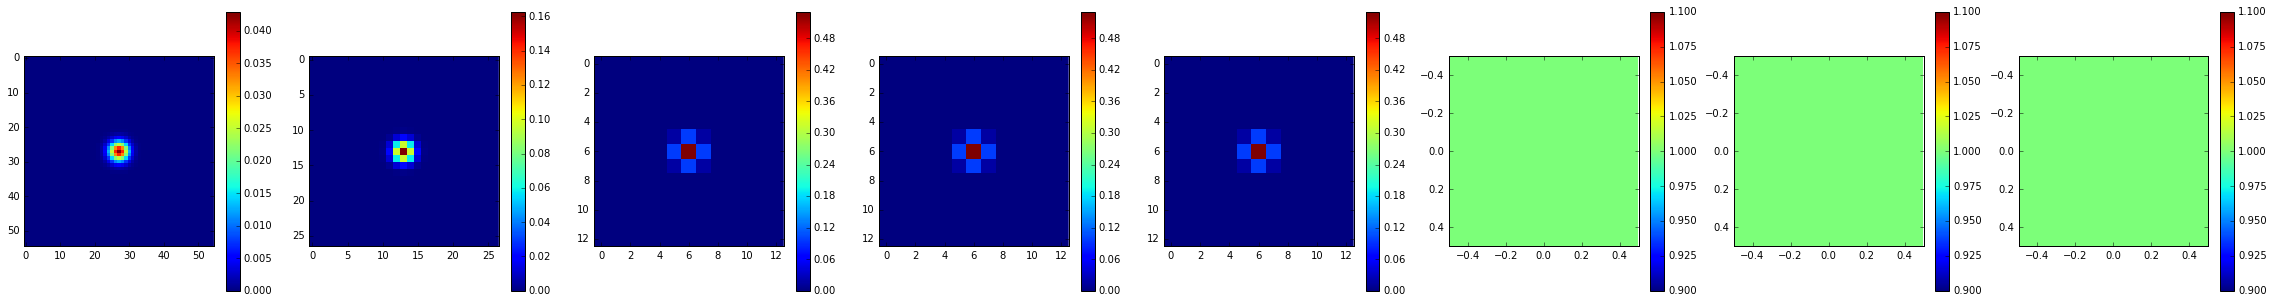

In [21]:
ith_rf_size = 0

n = len(fmaps_sizes)
plt.figure(figsize=(5*n,5))
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
for i,r in enumerate(fmaps_sizes):
    _,_,z = pnu.make_gaussian_mass(0., 0., sigmas[ith_rf_size], r[2], size=20.)
    plt.subplot(1,n,i+1)
    plt.imshow(z, interpolation='None')
    plt.colorbar()

## Define the model
### The model allocates the necessary buffers and pre-compile the theano expressions.
### The model can then be used in 2 fashion:
1) By precomputing explicitely the modelspace tensor (MST) for all samples and then using the training and validation part of the MST as input to the training and validating function with the argument use_data_as_rfw_data=True.

2) By feeding the feature maps directly to the training and validation routines. The modelspace tensor will be computed under the hood. Since this may take an inordinate amount of time with hi-resolution feature maps, it is recommended to use (1).  

In [22]:
fwrf = FWRF_model(_fmaps, fmaps_sizes, _invar, fmaps_sizes,
    batches_p=(200, ny*nx), batches_o=(200, 300, ny*nx), batches_t=(200, 10*ny*nx),\
    view_angle=lx, verbose=True)

CREATING SYMBOLS

> rfw 0 with shape (1, 225, 55, 55)
> rfw 1 with shape (1, 225, 27, 27)
> rfw 2 with shape (1, 225, 13, 13)
> rfw 3 with shape (1, 225, 13, 13)
> rfw 4 with shape (1, 225, 13, 13)
> rfw 5 with shape (1, 225, 1, 1)
> rfw 6 with shape (1, 225, 1, 1)
> rfw 7 with shape (1, 225, 1, 1)
  total number of feature maps = 4424, in 8 layers
  shared rfw using approx 3.7 Mb of memory (VRAM and RAM)


Layer	: <lasagne.layers.input.InputLayer object at 0x7f082a72f1d0>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 4424, 225)


Layer	: <src.pyFWRF.svFWRFLayer object at 0x7f082a72f290>
Name	: None
Type	: <class 'src.pyFWRF.svFWRFLayer'>
Shape	: (None, 300, 225)
Params
        |-- W         : (4424, 300, 225)
        |-- b         : (1, 300, 225)



COMPILING...
5.22 seconds to compile theano functions


## Precompute and save the modelspace tensor

In [23]:
#log_act_func = lambda x: np.log(1+np.sqrt(np.abs(x)))
all_rfw_data = fwrf.precompute_rfw_data(allFmaps, sharedModel_specs, verbose=True, dry_run=False, nonlinearity=None, zscore=True, trn_size=trn_size, epsilon=1e-3)
print all_rfw_data.shape


>> Storing the full precomputed candidate feature time series will require approx 55.474Gb of RAM!
>> Will be divided in chunks of 6.934Gb of VRAM!

Precomputing rfw candidate responses...


100%|██████████| 8/8 [00:42<00:00,  5.13s/it]

1800 rfw candidate responses took 42.545s @ 42.308 models/s
Z-scoring modelspace tensor...



8it [04:19, 32.55s/it]

(1870, 4424, 1, 1800)


In [24]:
print np.amin(all_rfw_data), np.amax(all_rfw_data)

-24.8207 1306.61


In [25]:
# split the model space tensor into trn and val set.
trn_rfw_data = all_rfw_data[:trn_size]
val_rfw_data = all_rfw_data[trn_size:]

## Run the models

In [26]:
lr = 1e-4
num_epochs = 20

val_scores, best_scores, best_abs_models, best_rel_models, best_params = fwrf.shared_model_training(\
    trn_rfw_data, trnVoxelData, sharedModel_specs, voxelParams,\
    val_test_size=350, lr=lr, l2=0., num_epochs=num_epochs, output_val_scores=True, verbose=True, dry_run=False, use_data_as_rfw_data=True)


Voxel-Candidates model optimization...
75 voxel batches of size 300 with residual 201
8 candidate batches of size 225 with residual 0
for 40861800 voxelmodel fits.


0it [00:00, ?it/s]


  Voxel 0:300 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005706
    validation <loss>: 0.005708
    validation <loss>: 0.005712
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005763
    validation <loss>: 0.005766
    validation <loss>: 0.005770
    validation <loss>: 0.005774
    validation <loss>: 0.005778
    validation <loss>: 0.005781
    20 Epoch for 67500 voxelmodels took 93.511s @ 721.840 voxelmodels/s

  Voxel 0:300 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005706
    validation <loss>: 0.005708
    validation <loss>: 0.005712
    validation <loss>: 0.005716
    validation <loss>: 0.005721
    validation <loss>: 0.005

1it [12:51, 771.88s/it]


  Voxel 300:600 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005687
    validation <loss>: 0.005671
    validation <loss>: 0.005664
    validation <loss>: 0.005661
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005661
    validation <loss>: 0.005662
    validation <loss>: 0.005664
    validation <loss>: 0.005666
    validation <loss>: 0.005669
    validation <loss>: 0.005671
    validation <loss>: 0.005674
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005685
    validation <loss>: 0.005688
    validation <loss>: 0.005691
    validation <loss>: 0.005693
    20 Epoch for 67500 voxelmodels took 93.433s @ 722.446 voxelmodels/s

  Voxel 300:600 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005687
    validation <loss>: 0.005671
    validation <loss>: 0.005663
    validation <loss>: 0.005660
    validation <loss>: 0.005659
    validation <loss>: 0

2it [25:42, 771.36s/it]


  Voxel 600:900 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005714
    validation <loss>: 0.005715
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005725
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005748
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005761
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    20 Epoch for 67500 voxelmodels took 93.389s @ 722.785 voxelmodels/s

  Voxel 600:900 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005726
    validation <loss>: 0

3it [38:31, 770.72s/it]


  Voxel 900:1200 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005713
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005735
    validation <loss>: 0.005739
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005776
    validation <loss>: 0.005780
    validation <loss>: 0.005784
    validation <loss>: 0.005788
    validation <loss>: 0.005792
    20 Epoch for 67500 voxelmodels took 93.072s @ 725.245 voxelmodels/s

  Voxel 900:1200 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005713
    validation <loss>: 0.005716
    validation <loss>: 0.005721
    validation <loss>: 0.005725
    validation <loss>: 0.005730
    validation <loss>:

4it [51:29, 772.95s/it]


  Voxel 1200:1500 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005711
    validation <loss>: 0.005711
    validation <loss>: 0.005713
    validation <loss>: 0.005716
    validation <loss>: 0.005720
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005740
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    validation <loss>: 0.005775
    validation <loss>: 0.005779
    20 Epoch for 67500 voxelmodels took 96.128s @ 702.187 voxelmodels/s

  Voxel 1200:1500 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005711
    validation <loss>: 0.005710
    validation <loss>: 0.005712
    validation <loss>: 0.005716
    validation <loss>: 0.005719
    validation <loss

5it [1:04:27, 774.62s/it]


  Voxel 1500:1800 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005669
    validation <loss>: 0.005648
    validation <loss>: 0.005638
    validation <loss>: 0.005632
    validation <loss>: 0.005630
    validation <loss>: 0.005629
    validation <loss>: 0.005629
    validation <loss>: 0.005629
    validation <loss>: 0.005631
    validation <loss>: 0.005632
    validation <loss>: 0.005634
    validation <loss>: 0.005636
    validation <loss>: 0.005638
    validation <loss>: 0.005641
    validation <loss>: 0.005643
    validation <loss>: 0.005645
    validation <loss>: 0.005648
    validation <loss>: 0.005651
    validation <loss>: 0.005653
    validation <loss>: 0.005656
    20 Epoch for 67500 voxelmodels took 93.448s @ 722.323 voxelmodels/s

  Voxel 1500:1800 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005668
    validation <loss>: 0.005647
    validation <loss>: 0.005636
    validation <loss>: 0.005631
    validation <loss>: 0.005628
    validation <loss

6it [1:17:17, 773.21s/it]


  Voxel 1800:2100 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005729
    validation <loss>: 0.005728
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005771
    validation <loss>: 0.005775
    validation <loss>: 0.005779
    validation <loss>: 0.005783
    validation <loss>: 0.005786
    validation <loss>: 0.005790
    validation <loss>: 0.005794
    20 Epoch for 67500 voxelmodels took 93.359s @ 723.016 voxelmodels/s

  Voxel 1800:2100 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss

7it [1:30:07, 772.12s/it]


  Voxel 2100:2400 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005716
    validation <loss>: 0.005719
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005733
    validation <loss>: 0.005738
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    20 Epoch for 67500 voxelmodels took 93.075s @ 725.221 voxelmodels/s

  Voxel 2100:2400 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005716
    validation <loss>: 0.005719
    validation <loss>: 0.005724
    validation <loss>: 0.005729
    validation <loss>: 0.005734
    validation <loss

8it [1:42:57, 771.36s/it]


  Voxel 2400:2700 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005729
    validation <loss>: 0.005732
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005746
    validation <loss>: 0.005751
    validation <loss>: 0.005755
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005790
    validation <loss>: 0.005794
    validation <loss>: 0.005798
    validation <loss>: 0.005802
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    20 Epoch for 67500 voxelmodels took 93.374s @ 722.899 voxelmodels/s

  Voxel 2400:2700 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005729
    validation <loss>: 0.005732
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005746
    validation <loss

9it [1:55:46, 770.66s/it]


  Voxel 2700:3000 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005743
    validation <loss>: 0.005746
    validation <loss>: 0.005750
    validation <loss>: 0.005754
    validation <loss>: 0.005758
    validation <loss>: 0.005763
    validation <loss>: 0.005767
    validation <loss>: 0.005771
    validation <loss>: 0.005776
    validation <loss>: 0.005780
    validation <loss>: 0.005784
    validation <loss>: 0.005788
    validation <loss>: 0.005792
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    validation <loss>: 0.005804
    validation <loss>: 0.005808
    validation <loss>: 0.005812
    validation <loss>: 0.005816
    validation <loss>: 0.005820
    20 Epoch for 67500 voxelmodels took 93.048s @ 725.433 voxelmodels/s

  Voxel 2700:3000 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005744
    validation <loss>: 0.005746
    validation <loss>: 0.005750
    validation <loss>: 0.005754
    validation <loss>: 0.005759
    validation <loss

10it [2:08:36, 770.46s/it]


  Voxel 3000:3300 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005711
    validation <loss>: 0.005695
    validation <loss>: 0.005686
    validation <loss>: 0.005681
    validation <loss>: 0.005679
    validation <loss>: 0.005678
    validation <loss>: 0.005678
    validation <loss>: 0.005679
    validation <loss>: 0.005680
    validation <loss>: 0.005681
    validation <loss>: 0.005683
    validation <loss>: 0.005684
    validation <loss>: 0.005686
    validation <loss>: 0.005688
    validation <loss>: 0.005690
    validation <loss>: 0.005692
    validation <loss>: 0.005694
    validation <loss>: 0.005697
    validation <loss>: 0.005699
    validation <loss>: 0.005701
    20 Epoch for 67500 voxelmodels took 93.069s @ 725.266 voxelmodels/s

  Voxel 3000:3300 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005711
    validation <loss>: 0.005693
    validation <loss>: 0.005685
    validation <loss>: 0.005680
    validation <loss>: 0.005678
    validation <loss

11it [2:21:25, 770.06s/it]


  Voxel 3300:3600 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005676
    validation <loss>: 0.005646
    validation <loss>: 0.005629
    validation <loss>: 0.005620
    validation <loss>: 0.005614
    validation <loss>: 0.005610
    validation <loss>: 0.005609
    validation <loss>: 0.005608
    validation <loss>: 0.005608
    validation <loss>: 0.005609
    validation <loss>: 0.005610
    validation <loss>: 0.005611
    validation <loss>: 0.005613
    validation <loss>: 0.005615
    validation <loss>: 0.005617
    validation <loss>: 0.005619
    validation <loss>: 0.005622
    validation <loss>: 0.005624
    validation <loss>: 0.005626
    validation <loss>: 0.005629
    20 Epoch for 67500 voxelmodels took 93.431s @ 722.461 voxelmodels/s

  Voxel 3300:3600 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005674
    validation <loss>: 0.005645
    validation <loss>: 0.005628
    validation <loss>: 0.005618
    validation <loss>: 0.005612
    validation <loss

12it [2:34:15, 770.02s/it]


  Voxel 3600:3900 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005737
    validation <loss>: 0.005740
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005753
    validation <loss>: 0.005758
    validation <loss>: 0.005763
    validation <loss>: 0.005767
    validation <loss>: 0.005772
    validation <loss>: 0.005776
    validation <loss>: 0.005780
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <loss>: 0.005813
    validation <loss>: 0.005817
    20 Epoch for 67500 voxelmodels took 93.414s @ 722.590 voxelmodels/s

  Voxel 3600:3900 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005737
    validation <loss>: 0.005739
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005753
    validation <loss

13it [2:47:04, 769.80s/it]


  Voxel 3900:4200 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005717
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005746
    validation <loss>: 0.005750
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005763
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    validation <loss>: 0.005776
    validation <loss>: 0.005780
    validation <loss>: 0.005784
    validation <loss>: 0.005788
    validation <loss>: 0.005792
    validation <loss>: 0.005796
    20 Epoch for 67500 voxelmodels took 93.332s @ 723.227 voxelmodels/s

  Voxel 3900:4200 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005717
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss

14it [2:59:53, 769.63s/it]


  Voxel 4200:4500 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005718
    validation <loss>: 0.005720
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005750
    validation <loss>: 0.005754
    validation <loss>: 0.005758
    validation <loss>: 0.005762
    validation <loss>: 0.005766
    validation <loss>: 0.005770
    validation <loss>: 0.005774
    validation <loss>: 0.005778
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    20 Epoch for 67500 voxelmodels took 93.487s @ 722.027 voxelmodels/s

  Voxel 4200:4500 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005717
    validation <loss>: 0.005720
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss

15it [3:12:43, 769.67s/it]


  Voxel 4500:4800 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005743
    validation <loss>: 0.005746
    validation <loss>: 0.005750
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005786
    validation <loss>: 0.005790
    validation <loss>: 0.005794
    validation <loss>: 0.005798
    validation <loss>: 0.005802
    validation <loss>: 0.005806
    validation <loss>: 0.005810
    validation <loss>: 0.005814
    validation <loss>: 0.005818
    validation <loss>: 0.005822
    20 Epoch for 67500 voxelmodels took 93.388s @ 722.788 voxelmodels/s

  Voxel 4500:4800 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005755
    validation <loss>: 0.005760
    validation <loss

16it [3:25:33, 769.67s/it]


  Voxel 4800:5100 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005768
    validation <loss>: 0.005769
    validation <loss>: 0.005771
    validation <loss>: 0.005775
    validation <loss>: 0.005779
    validation <loss>: 0.005783
    validation <loss>: 0.005787
    validation <loss>: 0.005791
    validation <loss>: 0.005795
    validation <loss>: 0.005799
    validation <loss>: 0.005802
    validation <loss>: 0.005806
    validation <loss>: 0.005810
    validation <loss>: 0.005813
    validation <loss>: 0.005817
    validation <loss>: 0.005821
    validation <loss>: 0.005824
    validation <loss>: 0.005828
    validation <loss>: 0.005832
    validation <loss>: 0.005835
    20 Epoch for 67500 voxelmodels took 93.000s @ 725.809 voxelmodels/s

  Voxel 4800:5100 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005768
    validation <loss>: 0.005768
    validation <loss>: 0.005771
    validation <loss>: 0.005775
    validation <loss>: 0.005779
    validation <loss

17it [3:38:22, 769.56s/it]


  Voxel 5100:5400 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005699
    validation <loss>: 0.005676
    validation <loss>: 0.005664
    validation <loss>: 0.005657
    validation <loss>: 0.005653
    validation <loss>: 0.005651
    validation <loss>: 0.005650
    validation <loss>: 0.005650
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005659
    validation <loss>: 0.005661
    validation <loss>: 0.005663
    validation <loss>: 0.005665
    validation <loss>: 0.005668
    validation <loss>: 0.005670
    20 Epoch for 67500 voxelmodels took 93.126s @ 724.824 voxelmodels/s

  Voxel 5100:5400 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005699
    validation <loss>: 0.005675
    validation <loss>: 0.005663
    validation <loss>: 0.005656
    validation <loss>: 0.005652
    validation <loss

18it [3:51:11, 769.44s/it]


  Voxel 5400:5700 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005702
    validation <loss>: 0.005684
    validation <loss>: 0.005675
    validation <loss>: 0.005670
    validation <loss>: 0.005669
    validation <loss>: 0.005668
    validation <loss>: 0.005669
    validation <loss>: 0.005670
    validation <loss>: 0.005672
    validation <loss>: 0.005674
    validation <loss>: 0.005676
    validation <loss>: 0.005678
    validation <loss>: 0.005681
    validation <loss>: 0.005683
    validation <loss>: 0.005686
    validation <loss>: 0.005689
    validation <loss>: 0.005691
    validation <loss>: 0.005694
    validation <loss>: 0.005697
    validation <loss>: 0.005700
    20 Epoch for 67500 voxelmodels took 93.333s @ 723.216 voxelmodels/s

  Voxel 5400:5700 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005701
    validation <loss>: 0.005683
    validation <loss>: 0.005673
    validation <loss>: 0.005669
    validation <loss>: 0.005667
    validation <loss

19it [4:04:01, 769.49s/it]


  Voxel 5700:6000 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005729
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005761
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    20 Epoch for 67500 voxelmodels took 93.060s @ 725.339 voxelmodels/s

  Voxel 5700:6000 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005729
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss>: 0.005736
    validation <loss>: 0.005740
    validation <loss

20it [4:16:50, 769.49s/it]


  Voxel 6000:6300 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005724
    validation <loss>: 0.005724
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005761
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005784
    validation <loss>: 0.005788
    validation <loss>: 0.005792
    20 Epoch for 67500 voxelmodels took 93.400s @ 722.696 voxelmodels/s

  Voxel 6000:6300 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005724
    validation <loss>: 0.005724
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss

21it [4:29:41, 769.97s/it]


  Voxel 6300:6600 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005734
    validation <loss>: 0.005736
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005804
    validation <loss>: 0.005808
    20 Epoch for 67500 voxelmodels took 93.796s @ 719.646 voxelmodels/s

  Voxel 6300:6600 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005734
    validation <loss>: 0.005736
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss

22it [4:42:33, 770.44s/it]


  Voxel 6600:6900 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005779
    validation <loss>: 0.005783
    validation <loss>: 0.005787
    validation <loss>: 0.005792
    validation <loss>: 0.005797
    validation <loss>: 0.005802
    validation <loss>: 0.005807
    validation <loss>: 0.005811
    validation <loss>: 0.005816
    validation <loss>: 0.005820
    validation <loss>: 0.005824
    validation <loss>: 0.005829
    validation <loss>: 0.005833
    validation <loss>: 0.005837
    validation <loss>: 0.005841
    validation <loss>: 0.005845
    validation <loss>: 0.005849
    validation <loss>: 0.005853
    validation <loss>: 0.005857
    validation <loss>: 0.005861
    20 Epoch for 67500 voxelmodels took 93.619s @ 721.006 voxelmodels/s

  Voxel 6600:6900 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005779
    validation <loss>: 0.005783
    validation <loss>: 0.005787
    validation <loss>: 0.005792
    validation <loss>: 0.005797
    validation <loss

23it [4:55:24, 770.77s/it]


  Voxel 6900:7200 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005754
    validation <loss>: 0.005745
    validation <loss>: 0.005742
    validation <loss>: 0.005742
    validation <loss>: 0.005744
    validation <loss>: 0.005746
    validation <loss>: 0.005748
    validation <loss>: 0.005751
    validation <loss>: 0.005754
    validation <loss>: 0.005757
    validation <loss>: 0.005760
    validation <loss>: 0.005763
    validation <loss>: 0.005766
    validation <loss>: 0.005769
    validation <loss>: 0.005772
    validation <loss>: 0.005775
    validation <loss>: 0.005778
    validation <loss>: 0.005781
    validation <loss>: 0.005784
    validation <loss>: 0.005787
    20 Epoch for 67500 voxelmodels took 93.696s @ 720.418 voxelmodels/s

  Voxel 6900:7200 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005754
    validation <loss>: 0.005744
    validation <loss>: 0.005741
    validation <loss>: 0.005741
    validation <loss>: 0.005743
    validation <loss

24it [5:08:16, 771.05s/it]


  Voxel 7200:7500 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005652
    validation <loss>: 0.005610
    validation <loss>: 0.005587
    validation <loss>: 0.005573
    validation <loss>: 0.005565
    validation <loss>: 0.005560
    validation <loss>: 0.005556
    validation <loss>: 0.005554
    validation <loss>: 0.005553
    validation <loss>: 0.005553
    validation <loss>: 0.005553
    validation <loss>: 0.005554
    validation <loss>: 0.005555
    validation <loss>: 0.005556
    validation <loss>: 0.005557
    validation <loss>: 0.005558
    validation <loss>: 0.005560
    validation <loss>: 0.005562
    validation <loss>: 0.005563
    validation <loss>: 0.005565
    20 Epoch for 67500 voxelmodels took 93.667s @ 720.635 voxelmodels/s

  Voxel 7200:7500 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005650
    validation <loss>: 0.005608
    validation <loss>: 0.005585
    validation <loss>: 0.005571
    validation <loss>: 0.005562
    validation <loss

25it [5:21:07, 771.17s/it]


  Voxel 7500:7800 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005731
    validation <loss>: 0.005725
    validation <loss>: 0.005724
    validation <loss>: 0.005725
    validation <loss>: 0.005727
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss>: 0.005740
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005751
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005762
    validation <loss>: 0.005766
    validation <loss>: 0.005770
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005780
    20 Epoch for 67500 voxelmodels took 93.222s @ 724.079 voxelmodels/s

  Voxel 7500:7800 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005731
    validation <loss>: 0.005725
    validation <loss>: 0.005724
    validation <loss>: 0.005725
    validation <loss>: 0.005727
    validation <loss

26it [5:33:59, 771.26s/it]


  Voxel 7800:8100 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005751
    validation <loss>: 0.005752
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005763
    validation <loss>: 0.005767
    validation <loss>: 0.005771
    validation <loss>: 0.005775
    validation <loss>: 0.005780
    validation <loss>: 0.005784
    validation <loss>: 0.005788
    validation <loss>: 0.005792
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    validation <loss>: 0.005804
    validation <loss>: 0.005808
    validation <loss>: 0.005812
    validation <loss>: 0.005816
    validation <loss>: 0.005820
    validation <loss>: 0.005824
    20 Epoch for 67500 voxelmodels took 93.195s @ 724.285 voxelmodels/s

  Voxel 7800:8100 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005751
    validation <loss>: 0.005752
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005763
    validation <loss

27it [5:46:50, 771.20s/it]


  Voxel 8100:8400 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005739
    validation <loss>: 0.005740
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005755
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <loss>: 0.005813
    20 Epoch for 67500 voxelmodels took 93.702s @ 720.365 voxelmodels/s

  Voxel 8100:8400 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005739
    validation <loss>: 0.005740
    validation <loss>: 0.005743
    validation <loss>: 0.005746
    validation <loss>: 0.005751
    validation <loss

28it [5:59:42, 771.37s/it]


  Voxel 8400:8700 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005747
    validation <loss>: 0.005748
    validation <loss>: 0.005751
    validation <loss>: 0.005754
    validation <loss>: 0.005758
    validation <loss>: 0.005762
    validation <loss>: 0.005766
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005804
    validation <loss>: 0.005808
    validation <loss>: 0.005812
    validation <loss>: 0.005816
    20 Epoch for 67500 voxelmodels took 93.299s @ 723.483 voxelmodels/s

  Voxel 8400:8700 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005747
    validation <loss>: 0.005748
    validation <loss>: 0.005750
    validation <loss>: 0.005754
    validation <loss>: 0.005757
    validation <loss

29it [6:12:32, 771.12s/it]


  Voxel 8700:9000 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005781
    validation <loss>: 0.005782
    validation <loss>: 0.005786
    validation <loss>: 0.005790
    validation <loss>: 0.005794
    validation <loss>: 0.005798
    validation <loss>: 0.005803
    validation <loss>: 0.005807
    validation <loss>: 0.005811
    validation <loss>: 0.005815
    validation <loss>: 0.005819
    validation <loss>: 0.005823
    validation <loss>: 0.005827
    validation <loss>: 0.005831
    validation <loss>: 0.005835
    validation <loss>: 0.005839
    validation <loss>: 0.005843
    validation <loss>: 0.005846
    validation <loss>: 0.005850
    validation <loss>: 0.005854
    20 Epoch for 67500 voxelmodels took 93.436s @ 722.422 voxelmodels/s

  Voxel 8700:9000 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005781
    validation <loss>: 0.005782
    validation <loss>: 0.005786
    validation <loss>: 0.005790
    validation <loss>: 0.005794
    validation <loss

30it [6:25:23, 770.96s/it]


  Voxel 9000:9300 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005679
    validation <loss>: 0.005648
    validation <loss>: 0.005632
    validation <loss>: 0.005623
    validation <loss>: 0.005618
    validation <loss>: 0.005616
    validation <loss>: 0.005615
    validation <loss>: 0.005615
    validation <loss>: 0.005615
    validation <loss>: 0.005616
    validation <loss>: 0.005617
    validation <loss>: 0.005618
    validation <loss>: 0.005620
    validation <loss>: 0.005622
    validation <loss>: 0.005624
    validation <loss>: 0.005626
    validation <loss>: 0.005628
    validation <loss>: 0.005630
    validation <loss>: 0.005632
    validation <loss>: 0.005634
    20 Epoch for 67500 voxelmodels took 93.504s @ 721.895 voxelmodels/s

  Voxel 9000:9300 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005678
    validation <loss>: 0.005646
    validation <loss>: 0.005630
    validation <loss>: 0.005621
    validation <loss>: 0.005616
    validation <loss

31it [6:38:13, 770.66s/it]


  Voxel 9300:9600 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005705
    validation <loss>: 0.005680
    validation <loss>: 0.005667
    validation <loss>: 0.005660
    validation <loss>: 0.005656
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005659
    validation <loss>: 0.005661
    validation <loss>: 0.005663
    validation <loss>: 0.005665
    validation <loss>: 0.005668
    validation <loss>: 0.005671
    validation <loss>: 0.005673
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005685
    20 Epoch for 67500 voxelmodels took 93.505s @ 721.890 voxelmodels/s

  Voxel 9300:9600 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005705
    validation <loss>: 0.005680
    validation <loss>: 0.005667
    validation <loss>: 0.005660
    validation <loss>: 0.005656
    validation <loss

32it [6:51:03, 770.42s/it]


  Voxel 9600:9900 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005742
    validation <loss>: 0.005741
    validation <loss>: 0.005743
    validation <loss>: 0.005746
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005763
    validation <loss>: 0.005767
    validation <loss>: 0.005771
    validation <loss>: 0.005774
    validation <loss>: 0.005778
    validation <loss>: 0.005782
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    validation <loss>: 0.005803
    20 Epoch for 67500 voxelmodels took 93.450s @ 722.308 voxelmodels/s

  Voxel 9600:9900 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005742
    validation <loss>: 0.005741
    validation <loss>: 0.005743
    validation <loss>: 0.005746
    validation <loss>: 0.005749
    validation <loss

33it [7:03:52, 770.16s/it]


  Voxel 9900:10200 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005747
    validation <loss>: 0.005745
    validation <loss>: 0.005746
    validation <loss>: 0.005749
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005759
    validation <loss>: 0.005763
    validation <loss>: 0.005767
    validation <loss>: 0.005771
    validation <loss>: 0.005774
    validation <loss>: 0.005778
    validation <loss>: 0.005782
    validation <loss>: 0.005786
    validation <loss>: 0.005790
    validation <loss>: 0.005794
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    20 Epoch for 67500 voxelmodels took 93.429s @ 722.477 voxelmodels/s

  Voxel 9900:10200 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005747
    validation <loss>: 0.005745
    validation <loss>: 0.005746
    validation <loss>: 0.005749
    validation <loss>: 0.005752
    validation <lo

34it [7:16:42, 770.12s/it]


  Voxel 10200:10500 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005775
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <loss>: 0.005813
    validation <loss>: 0.005817
    validation <loss>: 0.005821
    validation <loss>: 0.005825
    validation <loss>: 0.005829
    validation <loss>: 0.005833
    validation <loss>: 0.005837
    validation <loss>: 0.005840
    validation <loss>: 0.005844
    validation <loss>: 0.005848
    20 Epoch for 67500 voxelmodels took 92.978s @ 725.980 voxelmodels/s

  Voxel 10200:10500 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005775
    validation <loss>: 0.005777
    validation <loss>: 0.005780
    validation <loss>: 0.005784
    validation <loss>: 0.005788
    validation <

35it [7:29:32, 769.90s/it]


  Voxel 10500:10800 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <loss>: 0.005814
    validation <loss>: 0.005818
    validation <loss>: 0.005823
    validation <loss>: 0.005827
    validation <loss>: 0.005831
    validation <loss>: 0.005835
    validation <loss>: 0.005839
    validation <loss>: 0.005843
    validation <loss>: 0.005847
    validation <loss>: 0.005851
    validation <loss>: 0.005855
    validation <loss>: 0.005859
    validation <loss>: 0.005863
    validation <loss>: 0.005867
    validation <loss>: 0.005871
    20 Epoch for 67500 voxelmodels took 93.040s @ 725.497 voxelmodels/s

  Voxel 10500:10800 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <

36it [7:42:21, 769.70s/it]


  Voxel 10800:11100 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005709
    validation <loss>: 0.005696
    validation <loss>: 0.005690
    validation <loss>: 0.005689
    validation <loss>: 0.005689
    validation <loss>: 0.005690
    validation <loss>: 0.005692
    validation <loss>: 0.005694
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005701
    validation <loss>: 0.005704
    validation <loss>: 0.005707
    validation <loss>: 0.005709
    validation <loss>: 0.005712
    validation <loss>: 0.005715
    validation <loss>: 0.005718
    validation <loss>: 0.005721
    validation <loss>: 0.005723
    validation <loss>: 0.005726
    20 Epoch for 67500 voxelmodels took 93.386s @ 722.808 voxelmodels/s

  Voxel 10800:11100 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005708
    validation <loss>: 0.005695
    validation <loss>: 0.005689
    validation <loss>: 0.005687
    validation <loss>: 0.005687
    validation <

37it [7:55:11, 769.73s/it]


  Voxel 11100:11400 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005690
    validation <loss>: 0.005667
    validation <loss>: 0.005655
    validation <loss>: 0.005649
    validation <loss>: 0.005646
    validation <loss>: 0.005645
    validation <loss>: 0.005645
    validation <loss>: 0.005646
    validation <loss>: 0.005647
    validation <loss>: 0.005649
    validation <loss>: 0.005651
    validation <loss>: 0.005653
    validation <loss>: 0.005655
    validation <loss>: 0.005658
    validation <loss>: 0.005660
    validation <loss>: 0.005663
    validation <loss>: 0.005666
    validation <loss>: 0.005668
    validation <loss>: 0.005671
    validation <loss>: 0.005674
    20 Epoch for 67500 voxelmodels took 93.068s @ 725.280 voxelmodels/s

  Voxel 11100:11400 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005690
    validation <loss>: 0.005668
    validation <loss>: 0.005656
    validation <loss>: 0.005650
    validation <loss>: 0.005647
    validation <

38it [8:08:00, 769.66s/it]


  Voxel 11400:11700 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005731
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005729
    validation <loss>: 0.005732
    validation <loss>: 0.005735
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    validation <loss>: 0.005775
    validation <loss>: 0.005779
    validation <loss>: 0.005783
    validation <loss>: 0.005786
    20 Epoch for 67500 voxelmodels took 93.405s @ 722.663 voxelmodels/s

  Voxel 11400:11700 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005731
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005729
    validation <loss>: 0.005731
    validation <

39it [8:20:50, 769.73s/it]


  Voxel 11700:12000 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005732
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005731
    validation <loss>: 0.005734
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    validation <loss>: 0.005776
    validation <loss>: 0.005780
    validation <loss>: 0.005784
    validation <loss>: 0.005788
    validation <loss>: 0.005791
    20 Epoch for 67500 voxelmodels took 93.392s @ 722.762 voxelmodels/s

  Voxel 11700:12000 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005732
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <

40it [8:33:40, 769.68s/it]


  Voxel 12000:12300 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005767
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <loss>: 0.005813
    validation <loss>: 0.005817
    validation <loss>: 0.005821
    validation <loss>: 0.005825
    validation <loss>: 0.005828
    validation <loss>: 0.005832
    validation <loss>: 0.005836
    validation <loss>: 0.005840
    20 Epoch for 67500 voxelmodels took 93.395s @ 722.740 voxelmodels/s

  Voxel 12000:12300 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005767
    validation <loss>: 0.005769
    validation <loss>: 0.005772
    validation <loss>: 0.005776
    validation <loss>: 0.005780
    validation <

41it [8:46:29, 769.55s/it]


  Voxel 12300:12600 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005786
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005802
    validation <loss>: 0.005806
    validation <loss>: 0.005811
    validation <loss>: 0.005815
    validation <loss>: 0.005820
    validation <loss>: 0.005824
    validation <loss>: 0.005828
    validation <loss>: 0.005832
    validation <loss>: 0.005836
    validation <loss>: 0.005840
    validation <loss>: 0.005844
    validation <loss>: 0.005848
    validation <loss>: 0.005852
    validation <loss>: 0.005856
    validation <loss>: 0.005860
    validation <loss>: 0.005863
    20 Epoch for 67500 voxelmodels took 93.389s @ 722.782 voxelmodels/s

  Voxel 12300:12600 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005786
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <

42it [8:59:18, 769.53s/it]


  Voxel 12600:12900 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005708
    validation <loss>: 0.005695
    validation <loss>: 0.005689
    validation <loss>: 0.005688
    validation <loss>: 0.005688
    validation <loss>: 0.005689
    validation <loss>: 0.005691
    validation <loss>: 0.005692
    validation <loss>: 0.005695
    validation <loss>: 0.005697
    validation <loss>: 0.005699
    validation <loss>: 0.005702
    validation <loss>: 0.005704
    validation <loss>: 0.005707
    validation <loss>: 0.005709
    validation <loss>: 0.005712
    validation <loss>: 0.005714
    validation <loss>: 0.005717
    validation <loss>: 0.005720
    validation <loss>: 0.005722
    20 Epoch for 67500 voxelmodels took 93.451s @ 722.301 voxelmodels/s

  Voxel 12600:12900 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005707
    validation <loss>: 0.005693
    validation <loss>: 0.005688
    validation <loss>: 0.005686
    validation <loss>: 0.005686
    validation <

43it [9:12:08, 769.60s/it]


  Voxel 12900:13200 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005697
    validation <loss>: 0.005672
    validation <loss>: 0.005659
    validation <loss>: 0.005653
    validation <loss>: 0.005649
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005649
    validation <loss>: 0.005651
    validation <loss>: 0.005652
    validation <loss>: 0.005654
    validation <loss>: 0.005657
    validation <loss>: 0.005659
    validation <loss>: 0.005661
    validation <loss>: 0.005664
    validation <loss>: 0.005666
    validation <loss>: 0.005669
    validation <loss>: 0.005671
    validation <loss>: 0.005674
    20 Epoch for 67500 voxelmodels took 93.103s @ 725.002 voxelmodels/s

  Voxel 12900:13200 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005697
    validation <loss>: 0.005672
    validation <loss>: 0.005659
    validation <loss>: 0.005652
    validation <loss>: 0.005649
    validation <

44it [9:24:58, 769.66s/it]


  Voxel 13200:13500 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005743
    validation <loss>: 0.005734
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005733
    validation <loss>: 0.005735
    validation <loss>: 0.005737
    validation <loss>: 0.005740
    validation <loss>: 0.005743
    validation <loss>: 0.005746
    validation <loss>: 0.005749
    validation <loss>: 0.005752
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005762
    validation <loss>: 0.005766
    validation <loss>: 0.005769
    validation <loss>: 0.005772
    validation <loss>: 0.005776
    validation <loss>: 0.005779
    20 Epoch for 67500 voxelmodels took 93.090s @ 725.105 voxelmodels/s

  Voxel 13200:13500 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005742
    validation <loss>: 0.005733
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005732
    validation <

45it [9:37:47, 769.48s/it]


  Voxel 13500:13800 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005767
    validation <loss>: 0.005766
    validation <loss>: 0.005767
    validation <loss>: 0.005770
    validation <loss>: 0.005774
    validation <loss>: 0.005778
    validation <loss>: 0.005782
    validation <loss>: 0.005786
    validation <loss>: 0.005790
    validation <loss>: 0.005795
    validation <loss>: 0.005799
    validation <loss>: 0.005803
    validation <loss>: 0.005807
    validation <loss>: 0.005811
    validation <loss>: 0.005815
    validation <loss>: 0.005819
    validation <loss>: 0.005823
    validation <loss>: 0.005827
    validation <loss>: 0.005831
    validation <loss>: 0.005835
    20 Epoch for 67500 voxelmodels took 93.406s @ 722.651 voxelmodels/s

  Voxel 13500:13800 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005767
    validation <loss>: 0.005765
    validation <loss>: 0.005767
    validation <loss>: 0.005770
    validation <loss>: 0.005774
    validation <

46it [9:50:37, 769.60s/it]


  Voxel 13800:14100 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005783
    validation <loss>: 0.005786
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005804
    validation <loss>: 0.005808
    validation <loss>: 0.005812
    validation <loss>: 0.005816
    validation <loss>: 0.005820
    validation <loss>: 0.005824
    validation <loss>: 0.005828
    validation <loss>: 0.005831
    validation <loss>: 0.005835
    validation <loss>: 0.005839
    validation <loss>: 0.005842
    validation <loss>: 0.005846
    20 Epoch for 67500 voxelmodels took 93.113s @ 724.925 voxelmodels/s

  Voxel 13800:14100 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005782
    validation <loss>: 0.005785
    validation <loss>: 0.005788
    validation <

47it [10:03:26, 769.40s/it]


  Voxel 14100:14400 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005771
    validation <loss>: 0.005772
    validation <loss>: 0.005776
    validation <loss>: 0.005779
    validation <loss>: 0.005784
    validation <loss>: 0.005788
    validation <loss>: 0.005792
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    validation <loss>: 0.005804
    validation <loss>: 0.005808
    validation <loss>: 0.005812
    validation <loss>: 0.005815
    validation <loss>: 0.005819
    validation <loss>: 0.005823
    validation <loss>: 0.005826
    validation <loss>: 0.005830
    validation <loss>: 0.005834
    validation <loss>: 0.005837
    validation <loss>: 0.005841
    20 Epoch for 67500 voxelmodels took 93.403s @ 722.672 voxelmodels/s

  Voxel 14100:14400 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005771
    validation <loss>: 0.005772
    validation <loss>: 0.005775
    validation <loss>: 0.005779
    validation <loss>: 0.005783
    validation <

48it [10:16:16, 769.53s/it]


  Voxel 14400:14700 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005710
    validation <loss>: 0.005685
    validation <loss>: 0.005672
    validation <loss>: 0.005665
    validation <loss>: 0.005662
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005661
    validation <loss>: 0.005662
    validation <loss>: 0.005663
    validation <loss>: 0.005665
    validation <loss>: 0.005667
    validation <loss>: 0.005669
    validation <loss>: 0.005671
    validation <loss>: 0.005673
    validation <loss>: 0.005675
    validation <loss>: 0.005677
    validation <loss>: 0.005680
    validation <loss>: 0.005682
    20 Epoch for 67500 voxelmodels took 93.388s @ 722.795 voxelmodels/s

  Voxel 14400:14700 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005709
    validation <loss>: 0.005683
    validation <loss>: 0.005670
    validation <loss>: 0.005663
    validation <loss>: 0.005659
    validation <

49it [10:29:05, 769.54s/it]


  Voxel 14700:15000 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005719
    validation <loss>: 0.005695
    validation <loss>: 0.005683
    validation <loss>: 0.005677
    validation <loss>: 0.005673
    validation <loss>: 0.005672
    validation <loss>: 0.005672
    validation <loss>: 0.005672
    validation <loss>: 0.005673
    validation <loss>: 0.005674
    validation <loss>: 0.005676
    validation <loss>: 0.005678
    validation <loss>: 0.005680
    validation <loss>: 0.005682
    validation <loss>: 0.005684
    validation <loss>: 0.005686
    validation <loss>: 0.005689
    validation <loss>: 0.005691
    validation <loss>: 0.005694
    validation <loss>: 0.005696
    20 Epoch for 67500 voxelmodels took 93.400s @ 722.697 voxelmodels/s

  Voxel 14700:15000 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005719
    validation <loss>: 0.005695
    validation <loss>: 0.005682
    validation <loss>: 0.005676
    validation <loss>: 0.005673
    validation <

50it [10:41:55, 769.60s/it]


  Voxel 15000:15300 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005783
    validation <loss>: 0.005777
    validation <loss>: 0.005775
    validation <loss>: 0.005776
    validation <loss>: 0.005778
    validation <loss>: 0.005781
    validation <loss>: 0.005784
    validation <loss>: 0.005787
    validation <loss>: 0.005790
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    validation <loss>: 0.005803
    validation <loss>: 0.005807
    validation <loss>: 0.005810
    validation <loss>: 0.005814
    validation <loss>: 0.005817
    validation <loss>: 0.005821
    validation <loss>: 0.005824
    validation <loss>: 0.005828
    20 Epoch for 67500 voxelmodels took 93.389s @ 722.787 voxelmodels/s

  Voxel 15000:15300 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005783
    validation <loss>: 0.005776
    validation <loss>: 0.005775
    validation <loss>: 0.005775
    validation <loss>: 0.005777
    validation <

51it [10:54:44, 769.54s/it]


  Voxel 15300:15600 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005788
    validation <loss>: 0.005788
    validation <loss>: 0.005790
    validation <loss>: 0.005793
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005804
    validation <loss>: 0.005808
    validation <loss>: 0.005812
    validation <loss>: 0.005816
    validation <loss>: 0.005820
    validation <loss>: 0.005824
    validation <loss>: 0.005828
    validation <loss>: 0.005832
    validation <loss>: 0.005836
    validation <loss>: 0.005840
    validation <loss>: 0.005844
    validation <loss>: 0.005848
    validation <loss>: 0.005852
    validation <loss>: 0.005856
    20 Epoch for 67500 voxelmodels took 93.412s @ 722.602 voxelmodels/s

  Voxel 15300:15600 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005788
    validation <loss>: 0.005787
    validation <loss>: 0.005790
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    validation <

52it [11:07:34, 769.67s/it]


  Voxel 15600:15900 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005776
    validation <loss>: 0.005776
    validation <loss>: 0.005779
    validation <loss>: 0.005782
    validation <loss>: 0.005785
    validation <loss>: 0.005789
    validation <loss>: 0.005792
    validation <loss>: 0.005796
    validation <loss>: 0.005799
    validation <loss>: 0.005803
    validation <loss>: 0.005806
    validation <loss>: 0.005810
    validation <loss>: 0.005813
    validation <loss>: 0.005817
    validation <loss>: 0.005820
    validation <loss>: 0.005823
    validation <loss>: 0.005827
    validation <loss>: 0.005830
    validation <loss>: 0.005834
    validation <loss>: 0.005837
    20 Epoch for 67500 voxelmodels took 93.046s @ 725.446 voxelmodels/s

  Voxel 15600:15900 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005776
    validation <loss>: 0.005776
    validation <loss>: 0.005778
    validation <loss>: 0.005781
    validation <loss>: 0.005785
    validation <

53it [11:20:24, 769.67s/it]


  Voxel 15900:16200 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005713
    validation <loss>: 0.005696
    validation <loss>: 0.005689
    validation <loss>: 0.005685
    validation <loss>: 0.005684
    validation <loss>: 0.005684
    validation <loss>: 0.005685
    validation <loss>: 0.005687
    validation <loss>: 0.005688
    validation <loss>: 0.005690
    validation <loss>: 0.005692
    validation <loss>: 0.005694
    validation <loss>: 0.005696
    validation <loss>: 0.005698
    validation <loss>: 0.005700
    validation <loss>: 0.005703
    validation <loss>: 0.005705
    validation <loss>: 0.005707
    validation <loss>: 0.005710
    validation <loss>: 0.005712
    20 Epoch for 67500 voxelmodels took 93.117s @ 724.898 voxelmodels/s

  Voxel 15900:16200 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005712
    validation <loss>: 0.005694
    validation <loss>: 0.005686
    validation <loss>: 0.005683
    validation <loss>: 0.005681
    validation <

54it [11:33:13, 769.52s/it]


  Voxel 16200:16500 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005716
    validation <loss>: 0.005695
    validation <loss>: 0.005684
    validation <loss>: 0.005679
    validation <loss>: 0.005676
    validation <loss>: 0.005676
    validation <loss>: 0.005676
    validation <loss>: 0.005677
    validation <loss>: 0.005678
    validation <loss>: 0.005680
    validation <loss>: 0.005682
    validation <loss>: 0.005684
    validation <loss>: 0.005686
    validation <loss>: 0.005689
    validation <loss>: 0.005691
    validation <loss>: 0.005694
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005702
    validation <loss>: 0.005704
    20 Epoch for 67500 voxelmodels took 93.364s @ 722.977 voxelmodels/s

  Voxel 16200:16500 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005715
    validation <loss>: 0.005693
    validation <loss>: 0.005682
    validation <loss>: 0.005677
    validation <loss>: 0.005674
    validation <

55it [11:46:03, 769.55s/it]


  Voxel 16500:16800 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005791
    validation <loss>: 0.005783
    validation <loss>: 0.005782
    validation <loss>: 0.005783
    validation <loss>: 0.005785
    validation <loss>: 0.005788
    validation <loss>: 0.005791
    validation <loss>: 0.005794
    validation <loss>: 0.005797
    validation <loss>: 0.005801
    validation <loss>: 0.005804
    validation <loss>: 0.005808
    validation <loss>: 0.005811
    validation <loss>: 0.005815
    validation <loss>: 0.005818
    validation <loss>: 0.005822
    validation <loss>: 0.005826
    validation <loss>: 0.005829
    validation <loss>: 0.005833
    validation <loss>: 0.005836
    20 Epoch for 67500 voxelmodels took 93.115s @ 724.909 voxelmodels/s

  Voxel 16500:16800 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005790
    validation <loss>: 0.005783
    validation <loss>: 0.005781
    validation <loss>: 0.005782
    validation <loss>: 0.005785
    validation <

56it [11:58:52, 769.48s/it]


  Voxel 16800:17100 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005800
    validation <loss>: 0.005798
    validation <loss>: 0.005799
    validation <loss>: 0.005802
    validation <loss>: 0.005805
    validation <loss>: 0.005808
    validation <loss>: 0.005812
    validation <loss>: 0.005816
    validation <loss>: 0.005820
    validation <loss>: 0.005824
    validation <loss>: 0.005828
    validation <loss>: 0.005832
    validation <loss>: 0.005835
    validation <loss>: 0.005839
    validation <loss>: 0.005843
    validation <loss>: 0.005847
    validation <loss>: 0.005851
    validation <loss>: 0.005855
    validation <loss>: 0.005859
    validation <loss>: 0.005863
    20 Epoch for 67500 voxelmodels took 93.403s @ 722.674 voxelmodels/s

  Voxel 16800:17100 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005800
    validation <loss>: 0.005798
    validation <loss>: 0.005799
    validation <loss>: 0.005801
    validation <loss>: 0.005804
    validation <

57it [12:11:42, 769.54s/it]


  Voxel 17100:17400 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005783
    validation <loss>: 0.005782
    validation <loss>: 0.005784
    validation <loss>: 0.005787
    validation <loss>: 0.005791
    validation <loss>: 0.005795
    validation <loss>: 0.005799
    validation <loss>: 0.005803
    validation <loss>: 0.005806
    validation <loss>: 0.005810
    validation <loss>: 0.005814
    validation <loss>: 0.005818
    validation <loss>: 0.005822
    validation <loss>: 0.005826
    validation <loss>: 0.005830
    validation <loss>: 0.005834
    validation <loss>: 0.005837
    validation <loss>: 0.005841
    validation <loss>: 0.005845
    validation <loss>: 0.005849
    20 Epoch for 67500 voxelmodels took 93.427s @ 722.492 voxelmodels/s

  Voxel 17100:17400 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005783
    validation <loss>: 0.005782
    validation <loss>: 0.005783
    validation <loss>: 0.005786
    validation <loss>: 0.005790
    validation <

58it [12:24:31, 769.51s/it]


  Voxel 17400:17700 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005707
    validation <loss>: 0.005693
    validation <loss>: 0.005687
    validation <loss>: 0.005685
    validation <loss>: 0.005685
    validation <loss>: 0.005686
    validation <loss>: 0.005687
    validation <loss>: 0.005689
    validation <loss>: 0.005691
    validation <loss>: 0.005693
    validation <loss>: 0.005695
    validation <loss>: 0.005697
    validation <loss>: 0.005699
    validation <loss>: 0.005702
    validation <loss>: 0.005704
    validation <loss>: 0.005707
    validation <loss>: 0.005709
    validation <loss>: 0.005712
    validation <loss>: 0.005714
    validation <loss>: 0.005717
    20 Epoch for 67500 voxelmodels took 93.421s @ 722.535 voxelmodels/s

  Voxel 17400:17700 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005706
    validation <loss>: 0.005692
    validation <loss>: 0.005686
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    validation <

59it [12:37:21, 769.56s/it]


  Voxel 17700:18000 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005700
    validation <loss>: 0.005679
    validation <loss>: 0.005668
    validation <loss>: 0.005663
    validation <loss>: 0.005660
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005660
    validation <loss>: 0.005661
    validation <loss>: 0.005662
    validation <loss>: 0.005664
    validation <loss>: 0.005665
    validation <loss>: 0.005667
    validation <loss>: 0.005669
    validation <loss>: 0.005671
    validation <loss>: 0.005673
    validation <loss>: 0.005675
    validation <loss>: 0.005678
    validation <loss>: 0.005680
    validation <loss>: 0.005682
    20 Epoch for 67500 voxelmodels took 93.401s @ 722.692 voxelmodels/s

  Voxel 17700:18000 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005699
    validation <loss>: 0.005677
    validation <loss>: 0.005665
    validation <loss>: 0.005660
    validation <loss>: 0.005657
    validation <

60it [12:50:10, 769.54s/it]


  Voxel 18000:18300 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005786
    validation <loss>: 0.005779
    validation <loss>: 0.005777
    validation <loss>: 0.005777
    validation <loss>: 0.005779
    validation <loss>: 0.005781
    validation <loss>: 0.005784
    validation <loss>: 0.005787
    validation <loss>: 0.005790
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    validation <loss>: 0.005799
    validation <loss>: 0.005802
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <loss>: 0.005812
    validation <loss>: 0.005815
    validation <loss>: 0.005819
    validation <loss>: 0.005822
    validation <loss>: 0.005825
    20 Epoch for 67500 voxelmodels took 93.422s @ 722.528 voxelmodels/s

  Voxel 18000:18300 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005786
    validation <loss>: 0.005778
    validation <loss>: 0.005776
    validation <loss>: 0.005777
    validation <loss>: 0.005779
    validation <

61it [13:03:00, 769.60s/it]


  Voxel 18300:18600 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005817
    validation <loss>: 0.005819
    validation <loss>: 0.005822
    validation <loss>: 0.005826
    validation <loss>: 0.005830
    validation <loss>: 0.005835
    validation <loss>: 0.005839
    validation <loss>: 0.005844
    validation <loss>: 0.005848
    validation <loss>: 0.005853
    validation <loss>: 0.005857
    validation <loss>: 0.005861
    validation <loss>: 0.005866
    validation <loss>: 0.005870
    validation <loss>: 0.005874
    validation <loss>: 0.005878
    validation <loss>: 0.005882
    validation <loss>: 0.005886
    validation <loss>: 0.005890
    validation <loss>: 0.005894
    20 Epoch for 67500 voxelmodels took 93.027s @ 725.597 voxelmodels/s

  Voxel 18300:18600 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005817
    validation <loss>: 0.005818
    validation <loss>: 0.005821
    validation <loss>: 0.005825
    validation <loss>: 0.005830
    validation <

62it [13:15:50, 769.59s/it]


  Voxel 18600:18900 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005731
    validation <loss>: 0.005727
    validation <loss>: 0.005728
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss>: 0.005736
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005746
    validation <loss>: 0.005749
    validation <loss>: 0.005752
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005762
    validation <loss>: 0.005765
    validation <loss>: 0.005768
    validation <loss>: 0.005771
    validation <loss>: 0.005774
    validation <loss>: 0.005777
    validation <loss>: 0.005780
    20 Epoch for 67500 voxelmodels took 93.076s @ 725.210 voxelmodels/s

  Voxel 18600:18900 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005731
    validation <loss>: 0.005726
    validation <loss>: 0.005727
    validation <loss>: 0.005729
    validation <loss>: 0.005732
    validation <

63it [13:28:39, 769.42s/it]


  Voxel 18900:19200 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005718
    validation <loss>: 0.005700
    validation <loss>: 0.005691
    validation <loss>: 0.005687
    validation <loss>: 0.005685
    validation <loss>: 0.005685
    validation <loss>: 0.005685
    validation <loss>: 0.005685
    validation <loss>: 0.005687
    validation <loss>: 0.005688
    validation <loss>: 0.005689
    validation <loss>: 0.005691
    validation <loss>: 0.005693
    validation <loss>: 0.005695
    validation <loss>: 0.005697
    validation <loss>: 0.005699
    validation <loss>: 0.005701
    validation <loss>: 0.005703
    validation <loss>: 0.005705
    validation <loss>: 0.005707
    20 Epoch for 67500 voxelmodels took 93.442s @ 722.376 voxelmodels/s

  Voxel 18900:19200 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005716
    validation <loss>: 0.005698
    validation <loss>: 0.005688
    validation <loss>: 0.005684
    validation <loss>: 0.005682
    validation <

64it [13:41:29, 769.64s/it]


  Voxel 19200:19500 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005769
    validation <loss>: 0.005759
    validation <loss>: 0.005755
    validation <loss>: 0.005755
    validation <loss>: 0.005756
    validation <loss>: 0.005758
    validation <loss>: 0.005761
    validation <loss>: 0.005764
    validation <loss>: 0.005767
    validation <loss>: 0.005770
    validation <loss>: 0.005773
    validation <loss>: 0.005776
    validation <loss>: 0.005779
    validation <loss>: 0.005783
    validation <loss>: 0.005786
    validation <loss>: 0.005789
    validation <loss>: 0.005793
    validation <loss>: 0.005796
    validation <loss>: 0.005800
    validation <loss>: 0.005803
    20 Epoch for 67500 voxelmodels took 93.049s @ 725.423 voxelmodels/s

  Voxel 19200:19500 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005769
    validation <loss>: 0.005758
    validation <loss>: 0.005755
    validation <loss>: 0.005755
    validation <loss>: 0.005756
    validation <

65it [13:54:18, 769.45s/it]


  Voxel 19500:19800 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005824
    validation <loss>: 0.005821
    validation <loss>: 0.005822
    validation <loss>: 0.005825
    validation <loss>: 0.005828
    validation <loss>: 0.005831
    validation <loss>: 0.005835
    validation <loss>: 0.005839
    validation <loss>: 0.005842
    validation <loss>: 0.005846
    validation <loss>: 0.005850
    validation <loss>: 0.005854
    validation <loss>: 0.005857
    validation <loss>: 0.005861
    validation <loss>: 0.005864
    validation <loss>: 0.005868
    validation <loss>: 0.005872
    validation <loss>: 0.005875
    validation <loss>: 0.005879
    validation <loss>: 0.005882
    20 Epoch for 67500 voxelmodels took 93.403s @ 722.673 voxelmodels/s

  Voxel 19500:19800 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005823
    validation <loss>: 0.005821
    validation <loss>: 0.005822
    validation <loss>: 0.005824
    validation <loss>: 0.005827
    validation <

66it [14:07:08, 769.62s/it]


  Voxel 19800:20100 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005727
    validation <loss>: 0.005719
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    validation <loss>: 0.005717
    validation <loss>: 0.005718
    validation <loss>: 0.005721
    validation <loss>: 0.005723
    validation <loss>: 0.005725
    validation <loss>: 0.005728
    validation <loss>: 0.005731
    validation <loss>: 0.005733
    validation <loss>: 0.005736
    validation <loss>: 0.005739
    validation <loss>: 0.005741
    validation <loss>: 0.005744
    validation <loss>: 0.005747
    validation <loss>: 0.005750
    validation <loss>: 0.005752
    validation <loss>: 0.005755
    20 Epoch for 67500 voxelmodels took 93.429s @ 722.474 voxelmodels/s

  Voxel 19800:20100 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005727
    validation <loss>: 0.005718
    validation <loss>: 0.005715
    validation <loss>: 0.005714
    validation <loss>: 0.005715
    validation <

67it [14:19:57, 769.53s/it]


  Voxel 20100:20400 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005755
    validation <loss>: 0.005739
    validation <loss>: 0.005732
    validation <loss>: 0.005728
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005728
    validation <loss>: 0.005729
    validation <loss>: 0.005730
    validation <loss>: 0.005732
    validation <loss>: 0.005733
    validation <loss>: 0.005735
    validation <loss>: 0.005737
    validation <loss>: 0.005739
    validation <loss>: 0.005741
    validation <loss>: 0.005743
    validation <loss>: 0.005745
    validation <loss>: 0.005747
    validation <loss>: 0.005749
    20 Epoch for 67500 voxelmodels took 93.439s @ 722.395 voxelmodels/s

  Voxel 20100:20400 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005753
    validation <loss>: 0.005737
    validation <loss>: 0.005729
    validation <loss>: 0.005725
    validation <loss>: 0.005723
    validation <

68it [14:32:47, 769.52s/it]


  Voxel 20400:20700 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005811
    validation <loss>: 0.005806
    validation <loss>: 0.005805
    validation <loss>: 0.005807
    validation <loss>: 0.005810
    validation <loss>: 0.005813
    validation <loss>: 0.005817
    validation <loss>: 0.005820
    validation <loss>: 0.005824
    validation <loss>: 0.005828
    validation <loss>: 0.005832
    validation <loss>: 0.005835
    validation <loss>: 0.005839
    validation <loss>: 0.005843
    validation <loss>: 0.005847
    validation <loss>: 0.005850
    validation <loss>: 0.005854
    validation <loss>: 0.005858
    validation <loss>: 0.005861
    validation <loss>: 0.005865
    20 Epoch for 67500 voxelmodels took 93.399s @ 722.706 voxelmodels/s

  Voxel 20400:20700 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005811
    validation <loss>: 0.005806
    validation <loss>: 0.005805
    validation <loss>: 0.005807
    validation <loss>: 0.005810
    validation <

69it [14:45:36, 769.42s/it]


  Voxel 20700:21000 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005764
    validation <loss>: 0.005763
    validation <loss>: 0.005765
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    validation <loss>: 0.005776
    validation <loss>: 0.005779
    validation <loss>: 0.005783
    validation <loss>: 0.005787
    validation <loss>: 0.005791
    validation <loss>: 0.005794
    validation <loss>: 0.005798
    validation <loss>: 0.005802
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <loss>: 0.005812
    validation <loss>: 0.005816
    validation <loss>: 0.005819
    validation <loss>: 0.005823
    validation <loss>: 0.005826
    20 Epoch for 67500 voxelmodels took 93.378s @ 722.868 voxelmodels/s

  Voxel 20700:21000 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005764
    validation <loss>: 0.005762
    validation <loss>: 0.005764
    validation <loss>: 0.005767
    validation <loss>: 0.005771
    validation <

70it [14:58:26, 769.52s/it]


  Voxel 21000:21300 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005757
    validation <loss>: 0.005740
    validation <loss>: 0.005732
    validation <loss>: 0.005728
    validation <loss>: 0.005727
    validation <loss>: 0.005726
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005728
    validation <loss>: 0.005729
    validation <loss>: 0.005731
    validation <loss>: 0.005732
    validation <loss>: 0.005734
    validation <loss>: 0.005735
    validation <loss>: 0.005737
    validation <loss>: 0.005739
    validation <loss>: 0.005741
    validation <loss>: 0.005743
    validation <loss>: 0.005745
    validation <loss>: 0.005747
    20 Epoch for 67500 voxelmodels took 93.059s @ 725.346 voxelmodels/s

  Voxel 21000:21300 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005755
    validation <loss>: 0.005738
    validation <loss>: 0.005729
    validation <loss>: 0.005725
    validation <loss>: 0.005723
    validation <

71it [15:11:16, 769.66s/it]


  Voxel 21300:21600 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005816
    validation <loss>: 0.005816
    validation <loss>: 0.005818
    validation <loss>: 0.005822
    validation <loss>: 0.005826
    validation <loss>: 0.005830
    validation <loss>: 0.005834
    validation <loss>: 0.005838
    validation <loss>: 0.005842
    validation <loss>: 0.005847
    validation <loss>: 0.005851
    validation <loss>: 0.005855
    validation <loss>: 0.005859
    validation <loss>: 0.005863
    validation <loss>: 0.005867
    validation <loss>: 0.005871
    validation <loss>: 0.005875
    validation <loss>: 0.005878
    validation <loss>: 0.005882
    validation <loss>: 0.005886
    20 Epoch for 67500 voxelmodels took 93.020s @ 725.649 voxelmodels/s

  Voxel 21300:21600 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005816
    validation <loss>: 0.005815
    validation <loss>: 0.005817
    validation <loss>: 0.005821
    validation <loss>: 0.005825
    validation <

72it [15:24:05, 769.49s/it]


  Voxel 21600:21900 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005750
    validation <loss>: 0.005745
    validation <loss>: 0.005744
    validation <loss>: 0.005746
    validation <loss>: 0.005748
    validation <loss>: 0.005751
    validation <loss>: 0.005754
    validation <loss>: 0.005757
    validation <loss>: 0.005760
    validation <loss>: 0.005763
    validation <loss>: 0.005766
    validation <loss>: 0.005769
    validation <loss>: 0.005772
    validation <loss>: 0.005775
    validation <loss>: 0.005778
    validation <loss>: 0.005781
    validation <loss>: 0.005784
    validation <loss>: 0.005787
    validation <loss>: 0.005790
    validation <loss>: 0.005793
    20 Epoch for 67500 voxelmodels took 93.444s @ 722.354 voxelmodels/s

  Voxel 21600:21900 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005750
    validation <loss>: 0.005744
    validation <loss>: 0.005743
    validation <loss>: 0.005744
    validation <loss>: 0.005747
    validation <

73it [15:36:55, 769.63s/it]


  Voxel 21900:22200 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005797
    validation <loss>: 0.005784
    validation <loss>: 0.005778
    validation <loss>: 0.005775
    validation <loss>: 0.005775
    validation <loss>: 0.005775
    validation <loss>: 0.005777
    validation <loss>: 0.005778
    validation <loss>: 0.005780
    validation <loss>: 0.005782
    validation <loss>: 0.005784
    validation <loss>: 0.005787
    validation <loss>: 0.005789
    validation <loss>: 0.005791
    validation <loss>: 0.005794
    validation <loss>: 0.005797
    validation <loss>: 0.005799
    validation <loss>: 0.005802
    validation <loss>: 0.005804
    validation <loss>: 0.005807
    20 Epoch for 67500 voxelmodels took 93.138s @ 724.733 voxelmodels/s

  Voxel 21900:22200 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005796
    validation <loss>: 0.005782
    validation <loss>: 0.005775
    validation <loss>: 0.005773
    validation <loss>: 0.005772
    validation <

74it [15:49:44, 769.55s/it]


  Voxel 22200:22500 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.005799
    validation <loss>: 0.005796
    validation <loss>: 0.005796
    validation <loss>: 0.005799
    validation <loss>: 0.005802
    validation <loss>: 0.005805
    validation <loss>: 0.005809
    validation <loss>: 0.005812
    validation <loss>: 0.005815
    validation <loss>: 0.005819
    validation <loss>: 0.005822
    validation <loss>: 0.005825
    validation <loss>: 0.005829
    validation <loss>: 0.005832
    validation <loss>: 0.005835
    validation <loss>: 0.005839
    validation <loss>: 0.005842
    validation <loss>: 0.005845
    validation <loss>: 0.005848
    validation <loss>: 0.005852
    20 Epoch for 67500 voxelmodels took 93.480s @ 722.077 voxelmodels/s

  Voxel 22200:22500 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.005798
    validation <loss>: 0.005795
    validation <loss>: 0.005795
    validation <loss>: 0.005798
    validation <loss>: 0.005801
    validation <

75it [16:02:34, 769.59s/it]


  Voxel 22500:22701 of 22701, Candidate 0:225 of 1800
    validation <loss>: 0.003868
    validation <loss>: 0.003864
    validation <loss>: 0.003864
    validation <loss>: 0.003865
    validation <loss>: 0.003866
    validation <loss>: 0.003868
    validation <loss>: 0.003871
    validation <loss>: 0.003873
    validation <loss>: 0.003875
    validation <loss>: 0.003877
    validation <loss>: 0.003880
    validation <loss>: 0.003882
    validation <loss>: 0.003884
    validation <loss>: 0.003887
    validation <loss>: 0.003889
    validation <loss>: 0.003891
    validation <loss>: 0.003894
    validation <loss>: 0.003896
    validation <loss>: 0.003898
    validation <loss>: 0.003900
    20 Epoch for 45225 voxelmodels took 93.376s @ 484.333 voxelmodels/s

  Voxel 22500:22701 of 22701, Candidate 225:450 of 1800
    validation <loss>: 0.003867
    validation <loss>: 0.003864
    validation <loss>: 0.003863
    validation <loss>: 0.003864
    validation <loss>: 0.003866
    validation <

76it [16:15:23, 769.47s/it]


---------------------------------------------------------------------
20 Epoch for 40861800 voxelmodels took 58523.426s @ 698.213 voxelmodels/s


## Show a coarse distribution of position and sizes of the selected RFs

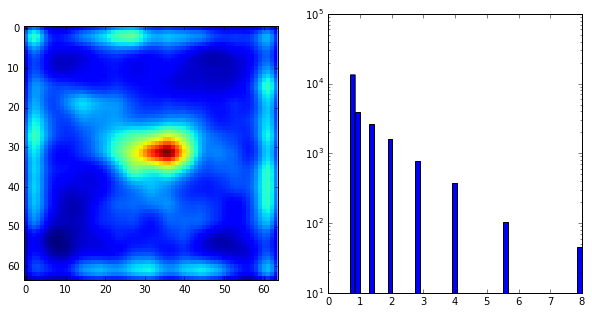

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_,_,g_stack = pnu.make_gaussian_stack(best_abs_models[:,0], best_abs_models[:,1], best_abs_models[:,2], 64, size=20., dtype=fpX)
plt.imshow(np.sum(g_stack, axis=0), interpolation='None')
plt.subplot(1,2,2)
_=plt.hist(best_abs_models[:,2], bins=50)
plt.yscale('log')

## If output_val_scores was set to True, display the validation score for all candidate of one voxels and the time series of the best candidates for all voxels.

[ 1.33333337  8.          0.99137908]
score range = (0.003507, 0.004581)


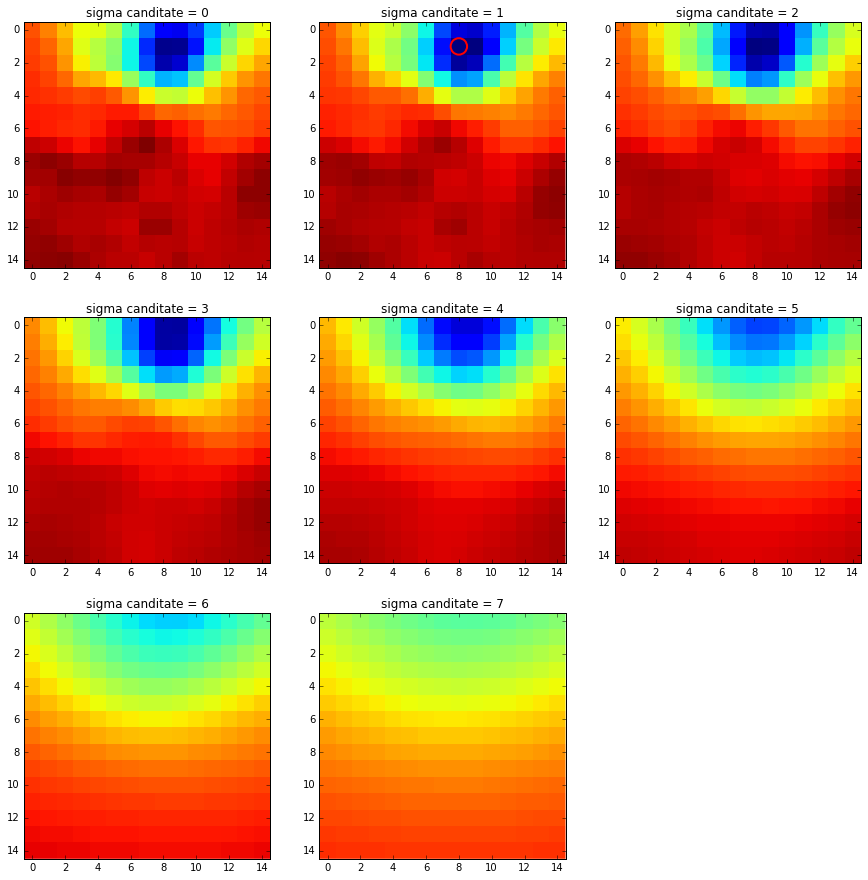

In [28]:
vidx = 3566
print best_abs_models[vidx,:]
fig1 = display_candidate_loss(val_scores[-1,vidx,:], nx, ny, ns)

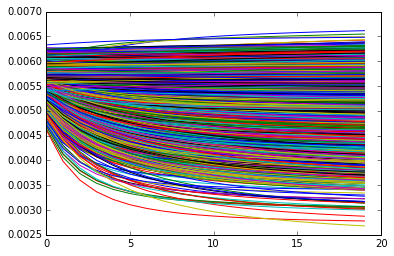

In [29]:
for v in range(val_scores.shape[1]):
    plt.plot(val_scores[:,v,best_rel_models[v]])

## Validate the best models and display the distribution of prediction accuracy.

In [30]:
val_pred, val_cc = fwrf.validate_models(val_rfw_data, valVoxelData, best_rel_models, best_params, use_data_as_rfw_data=True)

10 voxel batches of size 2250 with residual 201


11it [03:59, 21.79s/it]


max cc = 0.854285
sum(cc>0.2) = 3322


(-0.4, 0.9)

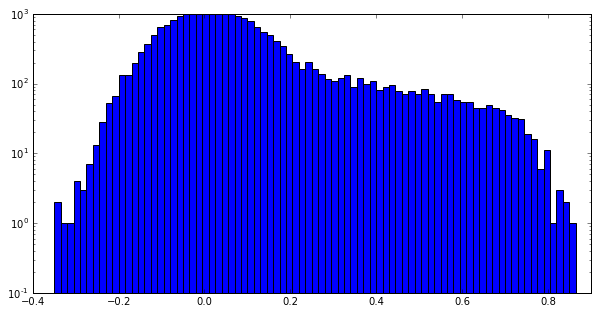

In [31]:
print "max cc = %f" % np.max(val_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_cc))
plt.figure(figsize=(10,5))
_=plt.hist(val_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

[[ 1.          0.82117533]
 [ 0.82117533  1.        ]]


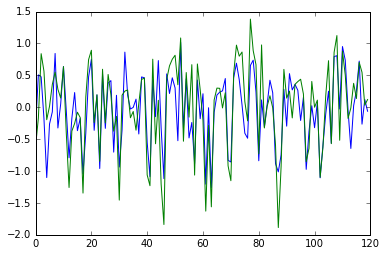

In [32]:
plt.plot(val_pred[:,vidx])
plt.plot(valVoxelData[:,vidx])

print np.corrcoef(val_pred[:,vidx], valVoxelData[:,vidx])

## Save the results

In [33]:
ex_file_name = "fwrf_%s_%s_%s_data.pkl" % (model_name, subject, timestamp)
ex_file = open(output_dir + ex_file_name, 'wb')
ex_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes,      
             'scores': best_scores,
             'models': best_abs_models,
             'params': best_params,
             'val_pred': val_pred,
             'val_cc': val_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

fwrf_deepnet_S1_Mar-25-2017_1549_data.pkl


# Split accuracy by layer and roi

In [34]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

[0, 96, 352, 736, 1120, 1376, 2400, 3424, 4424]


In [35]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_params[0][:, partitions[l]:partitions[l+1]]
    partition_params[1][:] = best_params[1][:]

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.validate_models(val_rfw_data, valVoxelData, best_rel_models, partition_params, use_data_as_rfw_data=True)

10 voxel batches of size 2250 with residual 201


11it [03:59, 21.80s/it]

10 voxel batches of size 2250 with residual 201



11it [03:59, 21.78s/it]

10 voxel batches of size 2250 with residual 201



11it [03:59, 21.81s/it]

10 voxel batches of size 2250 with residual 201



11it [03:59, 21.81s/it]

10 voxel batches of size 2250 with residual 201



11it [04:00, 21.82s/it]

10 voxel batches of size 2250 with residual 201



11it [03:59, 21.81s/it]

10 voxel batches of size 2250 with residual 201



11it [03:59, 21.79s/it]

10 voxel batches of size 2250 with residual 201



11it [03:59, 21.79s/it]


In [36]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], valVoxelData[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], valVoxelData[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [37]:
part_file = open(output_dir + "fwrf_%s_%s_%s_part.pkl" % (model_name, subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'val_pred': partition_val_pred,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [38]:
nROI = int(np.max(voxelROI))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxelROI.flatten()==roi, val_cc>0.2)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask] /  val_cc[roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

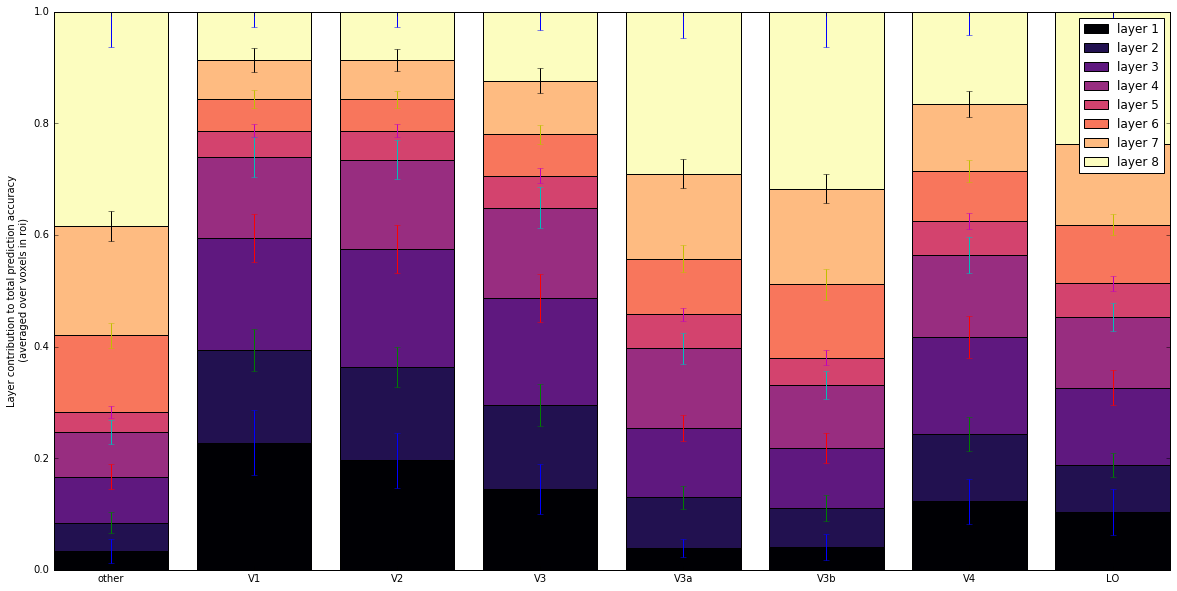

In [39]:
from matplotlib.pyplot import cm 
color=iter(cm.magma(np.linspace(0,1,nL)))

plt.figure(figsize=(20,10))
c=next(color)
plist = []
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], yerr=partition_R_std[0,:], color=c, align='center')
plist += [_,]
for l in range(1,nL):
    c=next(color)
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), yerr=partition_R_std[l,:], color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
plt.ylim([0,1])
plt.ylabel('Layer contribution to total prediction accuracy\n (averaged over voxels in roi)')